In [1]:
from ExtractContent import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prettyallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Sauvegarde des target
emailTargets = GetTrainingClassification("DataSet" + os.path.sep + "spam-mail.tr.label")

# genere le dataset de Trainning Testing
ExtractBodyFromDir("DataSet" + os.path.sep + "TR", "DataSet" + os.path.sep + "TRemailSet")
BuldingDataSet("DataSet" + os.path.sep + "TRemailSet", "DataSet" + os.path.sep + "TRemailSet", "DataSet" + os.path.sep + "TrainningSet.csv", emailTargets)

# genere le dataset de Testing
ExtractBodyFromDir("DataSet" + os.path.sep + "TT", "DataSet" + os.path.sep + "TTemailSet")
BuldingDataSet("DataSet" + os.path.sep + "TTemailSet", "DataSet" + os.path.sep + "TTemailSet", "DataSet" + os.path.sep + "TestingSet.csv", emailTargets)


In [3]:
# Chargement des dataset ".csv"
TrainDataSet = pd.read_csv("DataSet"+os.path.sep+"TrainningSet.csv", sep=';', names=('position','Subject', 'Content', 'SPAM'))
TestDataSet = pd.read_csv("DataSet"+os.path.sep+"TestingSet.csv", sep=';', names=('position','Subject', 'Content'))

In [4]:
TrainDataSet

,position,Subject,Content,SPAM
0,552,Re: K3B,B > `athalon-redhat-linux': machine `athalon-r...,1
1,1133,PROTECT YOUR FAMILYS FUTURE and Save up to 70%,% <html><head><title>ReliaQuote - Save Up To 7...,0
2,1655,"zzzz, do we have your money?","? <html><body bgcolor=""#FFFFFF""><TABLE cellSpa...",0
3,234,HELP WANTED. WORK FROM HOME. FREE INFO,O WE NEED HELP. We are a 14 year old fortune ...,0
4,2348,Detecting a closed SSL connection,n I've written my Apple Push Notification clie...,1
...,...,...,...,...
2495,239,Re: Supporting Apple Remote from a Java app?,? The email thread below is from fall of 2006....,1
2496,2351,Re: How to manage multiple Internet connections?,"? On Sat, 15 May 2010 16:32:05 +0200, Merciadr...",1
2497,2345,Line?,<html><head><title>Cell Booster Antenna</tit...,0
2498,1894,DONYA Photos 23758,8 <HTML><BODY></head><BODY><p>.&nbsp&nbsp Thes...,0


In [5]:
TestDataSet

,position,Subject,Content
0,1446,Codeine/Hydrocodone/Phentermin/Vicodin 7.5/750...,p Order from CanadianPharmacy & S...
1,1320,Re: Java is for kiddies,"s On Tue, 2002-08-27 at 08:58, Joseph S. Barre..."
2,1334,[spam] [SPAM] Jacob & Co. Watches,"s Content-Type: text/plain\tcharset=""iso-8859-..."
3,369,Re: asignar hora a PC,"C On Wed, 28 Apr 2010 10:03:15 -0400 (EDT), Ca..."
4,1452,Re: Problem detecting sleep in 10.6,"6 Hi Brandon,On 30 Apr 2010, at 17:14, Brandon..."
...,...,...,...
1822,416,Turkey City Lexicon,n URL: http://boingboing.net/#85506002Date: No...
1823,370,Re: Forged whitelist spam,m -----BEGIN PGP SIGNED MESSAGE-----Hash: SHA1...
1824,364,Re: Boot / LVM best practices,"s >>> If you're going to buy two drives, you'd..."
1825,1339,Re: Secure Sofware Key,y Yannick Gingras wrote:> I am wondering if...


In [6]:
#Vérifie et supprime les doublons 

#TrainDataSet.drop_duplicates(inplace = True)
#TestDataSet.drop_duplicates(inplace = True)

In [7]:
print("TrainDataSet =", TrainDataSet.shape)
print("TestDataSet  =", TestDataSet.shape)

TrainDataSet = (2500, 4)
TestDataSet  = (1827, 3)


In [8]:
#Afficher le nombre de données manquantes (NAN, NaN, na) pour chaque colonne du TrainDataSet
print( TrainDataSet.isnull().sum() )

#Afficher le nombre de données manquantes (NAN, NaN, na) pour chaque colonne du TestDataSet
print(TestDataSet.isnull().sum() )

position    0
Subject     2
Content     2
SPAM        0
dtype: int64
position    0
Subject     2
Content     2
dtype: int64


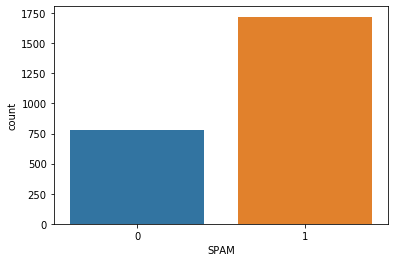

In [9]:
#Afficher le graphe du nombre de mail Spam et Non Spam
sns.countplot(TrainDataSet.SPAM)

In [10]:
#Statistique des SPAM et Non SPAM 
TrainDataSet.groupby('SPAM').describe()

position                                                             
        count         mean         std  min    25%     50%     75%     max
SPAM                                                                      
0       779.0  1231.064185  745.672856  1.0  574.0  1198.0  1905.0  2500.0
1      1721.0  1259.297501  710.824066  3.0  656.0  1264.0  1860.0  2499.0

In [11]:
process_msg(TestDataSet)
process_msg(TrainDataSet)

In [120]:
# separe le 'target' et les 'features' du DataSet de Trainning
y=pd.DataFrame(TrainDataSet.SPAM)
x=TrainDataSet

In [121]:
# ceration des variable d'entrainement et de de validation
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)

# ceration des variable de Testing
x_test = TestDataSet

In [122]:
x_train

,position,Subject,Content,SPAM,Text_clain,wordNum,messageLength
286,2160,Re: f-rpm] Python 2.2 site libs?,"? On Fri, 4 Oct 2002, Mark Derricutt wrote:> A...",1,fri 4 oct 2002 mark derricutt wrote anyon know...,116,476
1495,2094,"Fwd: [POLITICOS] Re: Bowling for Columbine, Op...",y Begin forwarded message:> From: Ian Andrew B...,1,begin forward messag ian andrew bell hello ian...,2110,6928
40,977,Dear hibody@csmining.org receive 80% OFF on Pf...,"r <!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 1.01...",0,r doctyp html public w3c dtd html 1 01 transit...,239,1180
1106,536,Get rid of those embarrassing wood scratches f...,"d <!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01...",0,doctyp html public w3c dtd html 4 01 en http w...,6196,28898
1379,1004,Paul Everitt: Interop in the Bazaar.,. URL: http://scriptingnews.userland.com/backi...,1,url http scriptingnew userland com backissu 20...,34,161
...,...,...,...,...,...,...,...
1033,443,Note to self: Read the pingback spec. Form opi...,. URL: http://scriptingnews.userland.com/backi...,1,url http scriptingnew userland com backissu 20...,38,181
1731,1162,Re: SF Weeklys Ultimate SF Date lineup :-),") On Mon, 23 Sep 2002, Russell Turpin wrote:--...",1,mon 23 sep 2002 russel turpin wrote better ide...,188,582
763,901,Awiating your fax response.,. (Fax) to my direct confidential Fax No: 23...,0,fax direct confidenti fax 234 1 7591666 dr kat...,681,2447
835,1379,[SPAM] Have a concrete thing in pants! Tiger ...,r Your male-pounder won't fall!http://zubzitqu...,0,r male pounder fall http zubzitquda com friend...,32,121


In [123]:
x_test

,position,Subject,Content,Text_clain,wordNum,messageLength
0,1446,Codeine/Hydrocodone/Phentermin/Vicodin 7.5/750...,p Order from CanadianPharmacy & S...,p order canadianpharmaci save money special ho...,82,466
1,1320,Re: Java is for kiddies,"s On Tue, 2002-08-27 at 08:58, Joseph S. Barre...",tue 2002 08 27 08 58 joseph barrera iii wrote ...,248,935
2,1334,[spam] [SPAM] Jacob & Co. Watches,"s Content-Type: text/plain\tcharset=""iso-8859-...",content type text plain charset iso 8859 1 con...,70,273
3,369,Re: asignar hora a PC,"C On Wed, 28 Apr 2010 10:03:15 -0400 (EDT), Ca...",c wed 28 apr 2010 10 03 15 0400 edt camal c3 b...,418,1339
4,1452,Re: Problem detecting sleep in 10.6,"6 Hi Brandon,On 30 Apr 2010, at 17:14, Brandon...",6 hi brandon 30 apr 2010 17 14 brandon moon wr...,120,562
...,...,...,...,...,...,...
1822,416,Turkey City Lexicon,n URL: http://boingboing.net/#85506002Date: No...,n url http boingbo net 85506002date suppliedaf...,286,1030
1823,370,Re: Forged whitelist spam,m -----BEGIN PGP SIGNED MESSAGE-----Hash: SHA1...,begin pgp sign messag hash sha1gordon mohr wro...,259,1028
1824,364,Re: Boot / LVM best practices,"s >>> If you're going to buy two drives, you'd...",go buy two drive stupid use mirror fault toler...,148,531
1825,1339,Re: Secure Sofware Key,y Yannick Gingras wrote:> I am wondering if...,yannick gingra wrote wonder techniqu make cd k...,347,1146


In [124]:
print("Moyenne Nomre de mots du DataSet d'entrainement :",int(TrainDataSet['wordNum'].mean() ) )

Moyenne Nomre de mots du DataSet d'entrainement : 417


In [125]:
print("Moyenne Nomre de mots du DataSet d'entrainement :",int(TestDataSet['wordNum'].mean() ) )

Moyenne Nomre de mots du DataSet d'entrainement : 446


In [126]:
max_feature=min(int(TrainDataSet['wordNum'].mean() ), int(TestDataSet['wordNum'].mean() ) )

In [127]:
# Vectorisation de comptage
# Il s'agit de compter le nombre d'occurrences de chaque mot dans le texte donné.

#pour le les donne d'entrainement
vectorize_Train=CountVectorizer(max_features=max_feature)
temp_train=vectorize_Train.fit_transform(x_train['Text_clain']).toarray()
temp_val=vectorize_Train.transform(x_val['Text_clain']).toarray()

#pour le les donne de Teste
vectorize_Test=CountVectorizer(max_features=max_feature)
temp_test=vectorize_Test.fit_transform(x_test['Text_clain']).toarray()

In [128]:
TestDataSet

,position,Subject,Content,Text_clain,wordNum,messageLength
0,1446,Codeine/Hydrocodone/Phentermin/Vicodin 7.5/750...,p Order from CanadianPharmacy & S...,p order canadianpharmaci save money special ho...,82,466
1,1320,Re: Java is for kiddies,"s On Tue, 2002-08-27 at 08:58, Joseph S. Barre...",tue 2002 08 27 08 58 joseph barrera iii wrote ...,248,935
2,1334,[spam] [SPAM] Jacob & Co. Watches,"s Content-Type: text/plain\tcharset=""iso-8859-...",content type text plain charset iso 8859 1 con...,70,273
3,369,Re: asignar hora a PC,"C On Wed, 28 Apr 2010 10:03:15 -0400 (EDT), Ca...",c wed 28 apr 2010 10 03 15 0400 edt camal c3 b...,418,1339
4,1452,Re: Problem detecting sleep in 10.6,"6 Hi Brandon,On 30 Apr 2010, at 17:14, Brandon...",6 hi brandon 30 apr 2010 17 14 brandon moon wr...,120,562
...,...,...,...,...,...,...
1822,416,Turkey City Lexicon,n URL: http://boingboing.net/#85506002Date: No...,n url http boingbo net 85506002date suppliedaf...,286,1030
1823,370,Re: Forged whitelist spam,m -----BEGIN PGP SIGNED MESSAGE-----Hash: SHA1...,begin pgp sign messag hash sha1gordon mohr wro...,259,1028
1824,364,Re: Boot / LVM best practices,"s >>> If you're going to buy two drives, you'd...",go buy two drive stupid use mirror fault toler...,148,531
1825,1339,Re: Secure Sofware Key,y Yannick Gingras wrote:> I am wondering if...,yannick gingra wrote wonder techniqu make cd k...,347,1146


In [129]:
TrainDataSet

,position,Subject,Content,SPAM,Text_clain,wordNum,messageLength
0,552,Re: K3B,B > `athalon-redhat-linux': machine `athalon-r...,1,b athalon redhat linux machin athalon redhat r...,198,823
1,1133,PROTECT YOUR FAMILYS FUTURE and Save up to 70%,% <html><head><title>ReliaQuote - Save Up To 7...,0,html head titl reliaquot save 70 life insur ti...,1281,6321
2,1655,"zzzz, do we have your money?","? <html><body bgcolor=""#FFFFFF""><TABLE cellSpa...",0,html bodi bgcolor ffffff tabl cellspac 0 cellp...,803,3530
3,234,HELP WANTED. WORK FROM HOME. FREE INFO,O WE NEED HELP. We are a 14 year old fortune ...,0,need help 14 year old fortun 500 compani grown...,132,461
4,2348,Detecting a closed SSL connection,n I've written my Apple Push Notification clie...,1,n written appl push notif client code java ser...,215,679
...,...,...,...,...,...,...,...
2495,239,Re: Supporting Apple Remote from a Java app?,? The email thread below is from fall of 2006....,1,email thread fall 2006 suppos anyon new commen...,298,1152
2496,2351,Re: How to manage multiple Internet connections?,"? On Sat, 15 May 2010 16:32:05 +0200, Merciadr...",1,sat 15 may 2010 16 32 05 0200 merciadri luca w...,197,750
2497,2345,Line?,<html><head><title>Cell Booster Antenna</tit...,0,html head titl cell booster antenna titl meta ...,358,1625
2498,1894,DONYA Photos 23758,8 <HTML><BODY></head><BODY><p>.&nbsp&nbsp Thes...,0,8 html bodi head bodi p nbsp nbsp real peopl r...,125,493


In [130]:
#tfidf : utiliser pour determiner à quel point un mot est important pour un texte dans un groupe de texte. 
#il est calculé en multipliant la fréquence d'un mot et la fréquence inverse du document 
#(la fréquence d'un mot, calculée par log (nombre de texte / nombre de texte contenant le mot)) du mot dans un groupe de texte.

#pour le les donne d'entrainement
tf_train=TfidfTransformer()

temp_train=tf_train.fit_transform(temp_train)
temp_val=tf_train.transform(temp_val)

#pour le les donne de Test
tf_test=TfidfTransformer()
temp_test=tf_test.fit_transform(temp_test)

In [131]:
#merging temp datafram avec le dataframe original

#pour les donne d'entrainement
temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

#pour le les donne de Test
temp_test=pd.DataFrame(temp_test.toarray(),index=x_test.index)
x_test=pd.concat([x_test,temp_test],axis=1,sort=False)


In [132]:
#supression de toutes les colonne des texte.

x_train.drop(['position'],axis=1,inplace=True)
x_train.drop(['Subject'],axis=1,inplace=True)
x_train.drop(['Content'],axis=1,inplace=True)
x_train.drop(['Text_clain'],axis=1,inplace=True)

x_val.drop(['position'],axis=1,inplace=True)
x_val.drop(['Subject'],axis=1,inplace=True)
x_val.drop(['Content'],axis=1,inplace=True)
x_val.drop(['Text_clain'],axis=1,inplace=True)

x_test.drop(['position'],axis=1,inplace=True)
x_test.drop(['Subject'],axis=1,inplace=True)
x_test.drop(['Content'],axis=1,inplace=True)
x_test.drop(['Text_clain'],axis=1,inplace=True)


In [133]:
x_train.head()

,SPAM,wordNum,messageLength,0,1,2,3,4,5,6,...,407,408,409,410,411,412,413,414,415,416
286,1,116,476,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.123897,0.0,0.106994,0.000000,0.000000,0.0,0.0,0.000000,0.0
1495,1,2110,6928,0.000000,0.032622,0.0,0.000000,0.0,0.0,0.030967,...,0.028014,0.238625,0.0,0.037467,0.032956,0.000000,0.0,0.0,0.078332,0.0
40,0,239,1180,0.000000,0.000000,0.0,0.046751,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.053691,0.054478,0.0,0.0,0.000000,0.0
1106,0,6196,28898,0.002362,0.000000,0.0,0.002449,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.011193,0.009845,0.000000,0.0,0.0,0.028972,0.0
1379,1,34,161,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.249261,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [134]:
x_test.head()

,wordNum,messageLength,0,1,2,3,4,5,6,7,...,407,408,409,410,411,412,413,414,415,416
0,82,466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,248,935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19946,...,0.0,0.0,0.000000,0.0,0.059529,0.0,0.0,0.0,0.0,0.0
2,70,273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,418,1339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.033134,0.0,0.056309,0.0,0.0,0.0,0.0,0.0
4,120,562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.063209,0.0,0.0,0.0,0.0,0.0


In [135]:


names = ["K_Nearest_Neighbors", "Decision_Tree", "Random_Forest", "Logistic_Regression", "SGD_Classifier", "Naive_Bayes", "SVM_Linear", "MLPClassifier"]

Y_preds={}

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear'),
    MLPClassifier()
]

models = zip(names, classifiers)
score = {}

for name, model in models:
    model.fit(x_train, y_train)
    y_preds = model.predict(x_val)
    Y_preds[name]=y_preds
    score[name]= [accuracy_score(y_val, y_preds), 0,0]
#     print("Precision: {:.2f}%".format(100 * precision_score(y_val, y_preds)))
#     print("Recall: {:.2f}%".format(100 * recall_score(y_val, y_preds)))
#     print("Confusion Matrix:\n") 
#     confusion_m = confusion_matrix(y_val, y_preds)
#     print(confusion_m)

In [136]:
score

{'K_Nearest_Neighbors': [0.802, 0, 0],
 'Decision_Tree': [1.0, 0, 0],
 'Random_Forest': [0.988, 0, 0],
 'Logistic_Regression': [1.0, 0, 0],
 'SGD_Classifier': [0.75, 0, 0],
 'Naive_Bayes': [0.884, 0, 0],
 'SVM_Linear': [0.994, 0, 0],
 'MLPClassifier': [0.956, 0, 0]}

In [137]:
save_results(names, score)
printfile()







        Table: Performance comparison and cross validation: Training set   

+-----------------------------------------------------------+
|ALGORITHME           |      evaluation  metrics            | 
+-----------------------------------------------------------+
|                     |  accuracy |  precision |     recall |
|###########################################################|
|  K_Nearest_Neighbors| 80.20 %   | 0.00 %   | 0.00 %   |
+-----------------------------------------------------------+           
|        Decision_Tree| 100.00 %   | 0.00 %   | 0.00 %   |
+-----------------------------------------------------------+           
|        Random_Forest| 98.80 %   | 0.00 %   | 0.00 %   |
+-----------------------------------------------------------+           
|  Logistic_Regression| 100.00 %   | 0.00 %   | 0.00 %   |
+-----------------------------------------------------------+           
|       SGD_Classifier| 75.00 %   | 0.00 %   | 0.00 %   |
+---------------------

In [138]:
modelHigtperformence=DecisionTreeClassifier(random_state=0)
modelHigtperformence.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [139]:
y_test = modelHigtperformence.predict(x_test)

ValueError: Number of features of the model must match the input. Model n_features is 420 and input n_features is 419 

In [ ]:
sns.countplot(Y_preds['K_Nearest_Neighbors'])